In [154]:
!pip install plotly_express

In [155]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.corpus import stopwords
import nltk
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.sparse.linalg import svds
import plotly_express as px
import random
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [156]:
# Load English stopwords
stop_words = set(stopwords.words('english'))

# Load data
reviews_df = pd.read_csv("E:/Pace/final/final_reviews.csv")
users_df = pd.read_csv("E:/Pace/final/users_final.csv")
businesses_df = pd.read_csv("E:/Pace/final/business_final.csv")
final_reviews = pd.read_csv("E:/Pace/final/final_reviews.csv")
final_reviews.drop(['Unnamed: 0'], axis=1, inplace = True)
print(final_reviews.shape)
final_reviews.head(3)

(76119, 25)


,business_id,user_id,stars,useful,funny,cool,text,date,year,month,...,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,Dominant_Topic,Keywords,Text_Chunks
0,SlLfWzeYOrVBxCd-0QILZQ,FLGFtGbXaUo0obR6lnZA1Q,5.0,2.0,0.0,1.0,My 2nd experience here was even better than th...,2017-02-19 21:43:00,2017.0,2.0,...,2nd experience even better first. believe kink...,0.306429,0.480476,0.000,0.742,0.258,0.9869,1.0,"food, place, great, service, well, love, alway...","['experience', 'well', 'first', 'believe', 'gr..."
1,sLgIenN5t-fFALQUkOvCyQ,tVMwKnashaK7V00XIRjtgw,5.0,1.0,0.0,0.0,We really liked this place. Everything we had ...,2018-02-01 22:44:20,2018.0,2.0,...,really liked place. everything delicious. port...,0.200000,0.570000,0.000,0.686,0.314,0.9091,1.0,"food, place, great, service, well, love, alway...","['really', 'like', 'place', 'delicious', 'port..."
2,Wr2k0Vz8RbcumYulp-jIrA,MLjsIHbz1UWQ65wGSs0Cqw,5.0,0.0,0.0,0.0,I love this place...stop whenever I can; eithe...,2015-05-12 18:07:21,2015.0,5.0,...,love place...stop whenever can; either locatio...,0.335714,0.435714,0.031,0.718,0.251,0.9686,1.0,"food, place, great, service, well, love, alway...","['love', 'place', 'stop', 'location', 'eat', '..."


# Creating a Super-Score Rating

In [157]:
# Computing Super-Score Rating for Reviews

final_reviews['super_score'] = final_reviews['polarity'] *  final_reviews['compound']
final_reviews['super_score'] = final_reviews['super_score'] + final_reviews['stars']
final_reviews.sample(3)

,business_id,user_id,stars,useful,funny,cool,text,date,year,month,...,polarity,subjectivity,neg,neu,pos,compound,Dominant_Topic,Keywords,Text_Chunks,super_score
65859,OjMEHt2F0PzJg7tb9mrTiA,onuc8Z0efBNIK-1QIGZ5ag,5.0,0.0,0.0,1.0,I can't believe I haven't written a review on ...,2018-05-27 14:19:49,2018.0,5.0,...,0.173401,0.558754,0.034,0.750,0.216,0.9815,2.0,"order, time, wait, food, give, ask, table, nev...","['disrespectful', 'waitress', 'blonde', 'haire...",5.170193
1405,k0AO8X3VzWe_F4lkMb0eSg,UdXbRbvWe-chJh2CSPN4oQ,5.0,0.0,0.0,0.0,This is some of the breakfast food around. I c...,2017-06-26 11:48:45,2017.0,6.0,...,0.589583,0.708333,0.023,0.863,0.114,0.8531,2.0,"order, time, wait, food, give, ask, table, nev...","['time', 'weekend', 'never', 'catch', 'open', ...",5.502974
11534,yRHKBFRoddwF5iVevkS4ww,IHNqLX2tHqGzULVYKmpQkw,4.0,1.0,1.0,0.0,Came on a Saturday night with no reservation a...,2016-02-06 18:52:44,2016.0,2.0,...,0.252083,0.541667,0.065,0.790,0.145,0.7579,2.0,"order, time, wait, food, give, ask, table, nev...","['hit', 'golf', 'ball', 'hard', 'satisfy', 'pl...",4.191054


In [158]:
# Checking whether there are any rows with zero super scores

final_reviews[final_reviews['super_score']==0.0]

,business_id,user_id,stars,useful,funny,cool,text,date,year,month,...,polarity,subjectivity,neg,neu,pos,compound,Dominant_Topic,Keywords,Text_Chunks,super_score


In [159]:
# Minimum Super Score Rating

final_reviews['super_score'].min()

0.23419999999999996

In [160]:
# Maximum Super Score Rating

final_reviews['super_score'].max()

5.9732165625

# Cold-Start Problem

# Location-Based Recommendation System

In [161]:
# Reading in Restaurant Businesses Final CSV File

business_final = pd.read_csv('E:/Pace/final/business_final.csv')
business_final.drop(['Unnamed: 0'], axis=1, inplace = True)
print(business_final.shape)
business_final.head(3)

(1237, 12)


,business_id,name,city,state,stars,review_count,categories,latitude,longitude,is_open,postal_code,key
0,8rb-3VYXE37IZix4yOdskw,Sharky's Sports Bar & Grill,Williamstown,NJ,2.5,29,"American (Traditional), Bars, Nightlife, Sport...",39.696801,-74.999821,1,8094,8rb-3VYXE37IZix4yOdskw
1,LhpPSrulqVeTyJeK2xydvQ,Fresh Fruits & Salads,Camden,NJ,4.5,6,"Juice Bars & Smoothies, Restaurants, Fruits & ...",39.946690,-75.123327,1,8102,LhpPSrulqVeTyJeK2xydvQ
2,Ms5xG8i4p80KSMcF3tt4ug,Sal DeForte's Ristorante,Ewing,NJ,4.0,52,"Italian, Restaurants",40.266888,-74.805657,1,8628,Ms5xG8i4p80KSMcF3tt4ug


In [162]:
# Filtering for Selected Columns

business_final['business_id'] = business_final['business_id ']
business_final = business_final[['business_id', 'name', 'categories','stars','review_count','latitude','longitude','postal_code']]
business_final.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code
0,8rb-3VYXE37IZix4yOdskw,Sharky's Sports Bar & Grill,"American (Traditional), Bars, Nightlife, Sport...",2.5,29,39.696801,-74.999821,8094
1,LhpPSrulqVeTyJeK2xydvQ,Fresh Fruits & Salads,"Juice Bars & Smoothies, Restaurants, Fruits & ...",4.5,6,39.946690,-75.123327,8102
2,Ms5xG8i4p80KSMcF3tt4ug,Sal DeForte's Ristorante,"Italian, Restaurants",4.0,52,40.266888,-74.805657,8628
3,Wt1W6qwCvna1KzIuJRJbwA,Tokyo Mandarin,"Japanese, Restaurants, Sushi Bars, Chinese",4.0,88,39.711938,-75.110967,8028
4,SlLfWzeYOrVBxCd-0QILZQ,The Boiling House,"Cajun/Creole, Seafood, Noodles, Restaurants",4.0,238,39.899661,-74.953300,8003


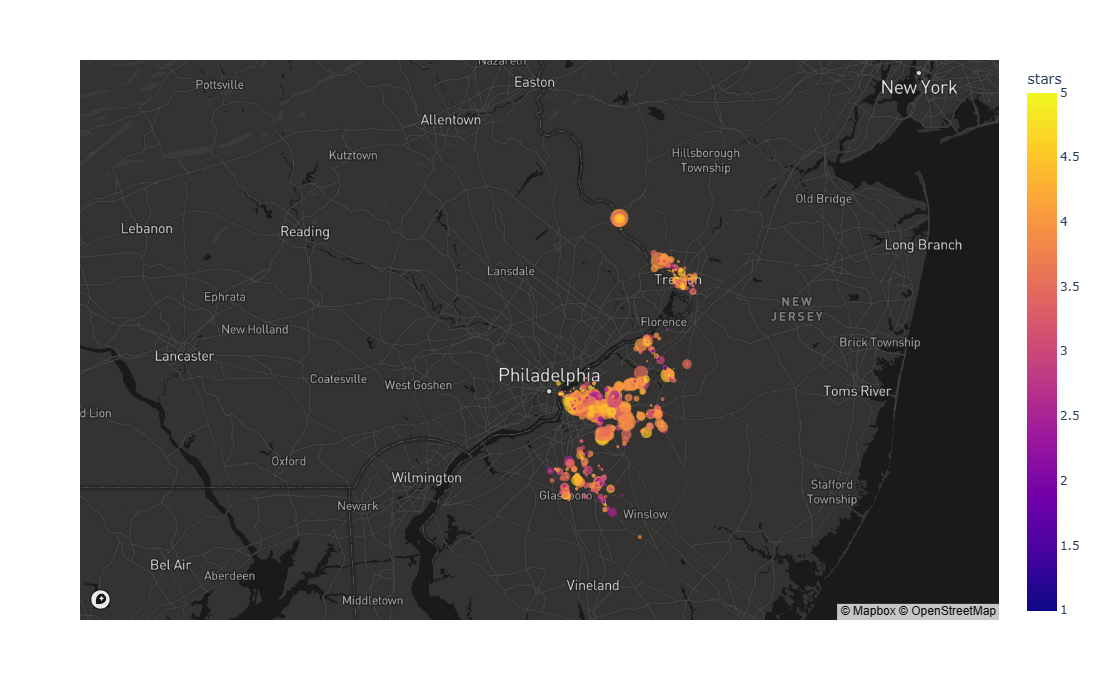

In [163]:
# Geographical Overview of Restaurants in New Jersey Area

px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
fig = px.scatter_mapbox(business_final, lat="latitude", lon="longitude", color="stars", size='review_count',
                   size_max=15, zoom=10, width=1000, height=700)

fig.update_layout(mapbox_style="dark")
fig.show()

# K-Means Clustering

In [164]:
# Putting the Coordinates of Restaurants together into a dataframe

coordinates = business_final[['longitude','latitude']]
coordinates

,longitude,latitude
0,-74.999821,39.696801
1,-75.123327,39.946690
2,-74.805657,40.266888
3,-75.110967,39.711938
4,-74.953300,39.899661
...,...,...
1232,-74.963596,39.940770
1233,-75.024127,39.750399
1234,-75.110969,39.702327
1235,-74.874646,39.971930


In [165]:
# Elbow method to determine the number of K in Kmeans Clustering

distortions = []
K = range(1,15)
for k in K:
    kmeansModel = KMeans(n_clusters=k)
    kmeansModel = kmeansModel.fit(coordinates)
    distortions.append(kmeansModel.inertia_)

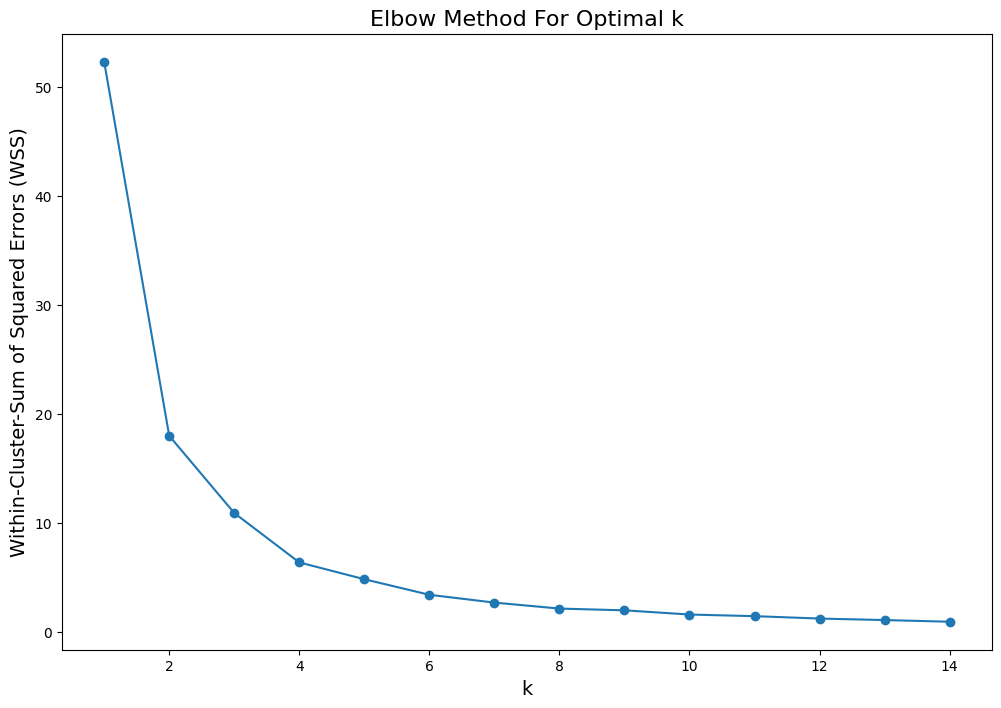

In [166]:
# Elbow Graph for WSS

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(K, distortions, marker='o')
plt.xlabel('k', fontsize = 14)
plt.ylabel('Within-Cluster-Sum of Squared Errors (WSS)', fontsize = 14)
plt.title('Elbow Method For Optimal k', fontsize = 16)
plt.show()

In [167]:
# Silhouette Score Method to to determine the number of K in Kmeans Clustering

sil = []
kmax = 25

# Dissimilarity would not be defined for a single cluster. Minimum number of clusters should be 2

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(coordinates)
  labels = kmeans.labels_
  sil.append(silhouette_score(coordinates, labels, metric = 'euclidean'))

In [168]:
# Silhouette Scores

sil

[0.6104248642067815,
 0.5350054303850857,
 0.5652776058959128,
 0.5252568602320847,
 0.5469930809845339,
 0.5416387981573392,
 0.525747262840521,
 0.5210688992314084,
 0.5209349009750719,
 0.5490174969563996,
 0.5627544130305437,
 0.5129857142303443,
 0.5326083550657821,
 0.5248900990751765,
 0.5165714004687122,
 0.47996725744117247,
 0.5235703060349026,
 0.49622795508465634,
 0.5146931713834226,
 0.5211845343170621,
 0.4977246218866784,
 0.49164419267877696,
 0.4792560956901632,
 0.5277186080331213]

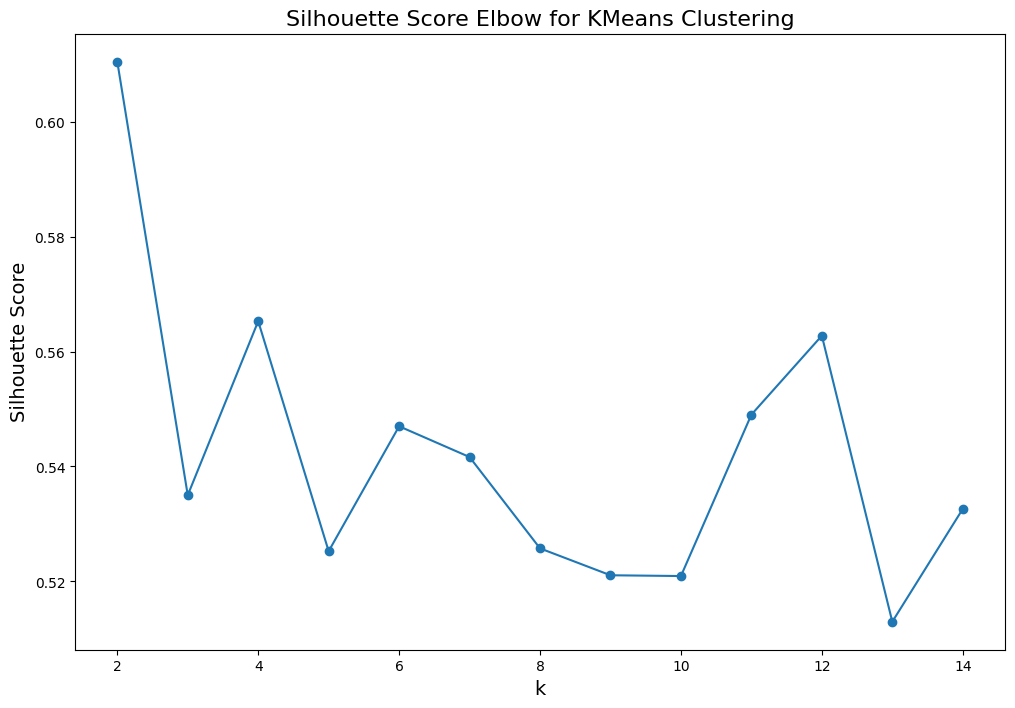

In [169]:
# Elbow Graph for Silhouette Score

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(K[1:15], sil[:13], marker='o')
plt.xlabel('k', fontsize = 14)
plt.ylabel('Silhouette Score', fontsize = 14)
plt.title('Silhouette Score Elbow for KMeans Clustering', fontsize = 16)
plt.show()

In [170]:
# Setting K = 4

kmeans = KMeans(n_clusters = 4, init = 'k-means++')
kmeans.fit(coordinates)
y = kmeans.labels_
print("k = 4", " silhouette_score ", silhouette_score(coordinates, y, metric='euclidean'))

k = 4  silhouette_score  0.5652776058959128


In [171]:
business_final['init_cluster'] = kmeans.predict(business_final[['longitude','latitude']])
business_final.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster
0,8rb-3VYXE37IZix4yOdskw,Sharky's Sports Bar & Grill,"American (Traditional), Bars, Nightlife, Sport...",2.5,29,39.696801,-74.999821,8094,0
1,LhpPSrulqVeTyJeK2xydvQ,Fresh Fruits & Salads,"Juice Bars & Smoothies, Restaurants, Fruits & ...",4.5,6,39.946690,-75.123327,8102,2
2,Ms5xG8i4p80KSMcF3tt4ug,Sal DeForte's Ristorante,"Italian, Restaurants",4.0,52,40.266888,-74.805657,8628,1
3,Wt1W6qwCvna1KzIuJRJbwA,Tokyo Mandarin,"Japanese, Restaurants, Sushi Bars, Chinese",4.0,88,39.711938,-75.110967,8028,0
4,SlLfWzeYOrVBxCd-0QILZQ,The Boiling House,"Cajun/Creole, Seafood, Noodles, Restaurants",4.0,238,39.899661,-74.953300,8003,2


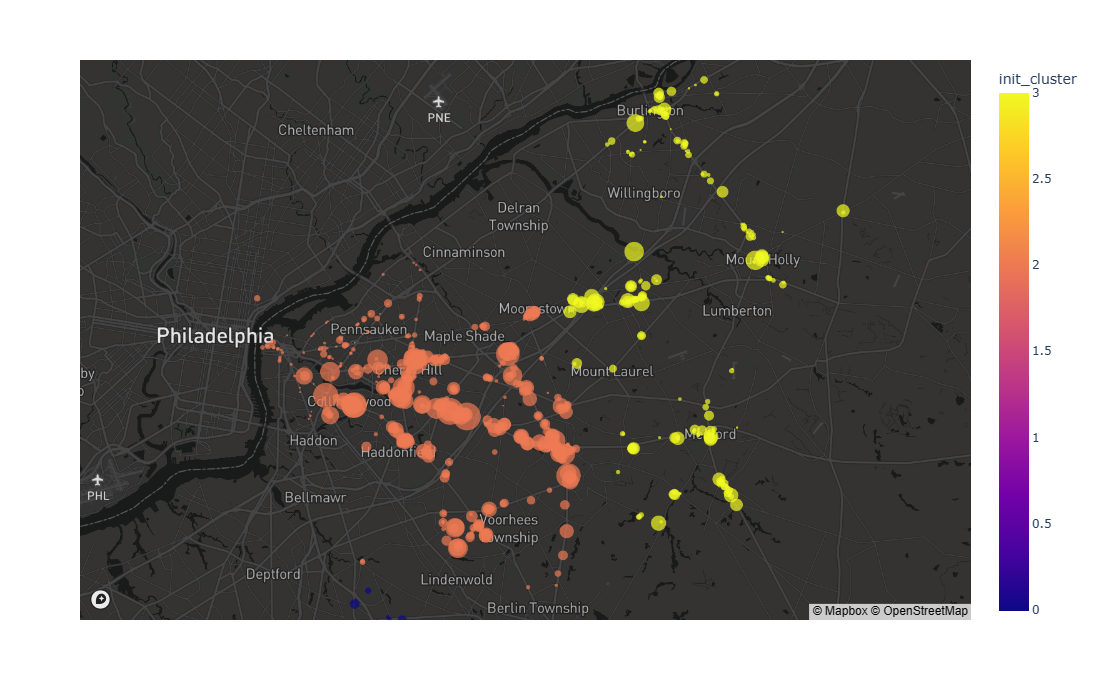

In [172]:
# Geographical Plot of 4 Clusters

px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
fig = px.scatter_mapbox(business_final, lat="latitude", lon="longitude", color="init_cluster", size='review_count',
                  hover_data= ['name', 'latitude', 'longitude'], zoom=10, width=1000, height=700)

fig.update_layout(mapbox_style="dark")
fig.show()

In [173]:
# Let's try k = 10

kmeans = KMeans(n_clusters = 10, init = 'k-means++')
kmeans.fit(coordinates)
y = kmeans.labels_
print("k = 10", " silhouette_score ", silhouette_score(coordinates, y, metric='euclidean'))

k = 10  silhouette_score  0.49342137689644655


In [174]:
business_final['cluster'] = kmeans.predict(business_final[['longitude','latitude']])
business_final.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster,cluster
0,8rb-3VYXE37IZix4yOdskw,Sharky's Sports Bar & Grill,"American (Traditional), Bars, Nightlife, Sport...",2.5,29,39.696801,-74.999821,8094,0,2
1,LhpPSrulqVeTyJeK2xydvQ,Fresh Fruits & Salads,"Juice Bars & Smoothies, Restaurants, Fruits & ...",4.5,6,39.946690,-75.123327,8102,2,4
2,Ms5xG8i4p80KSMcF3tt4ug,Sal DeForte's Ristorante,"Italian, Restaurants",4.0,52,40.266888,-74.805657,8628,1,7
3,Wt1W6qwCvna1KzIuJRJbwA,Tokyo Mandarin,"Japanese, Restaurants, Sushi Bars, Chinese",4.0,88,39.711938,-75.110967,8028,0,2
4,SlLfWzeYOrVBxCd-0QILZQ,The Boiling House,"Cajun/Creole, Seafood, Noodles, Restaurants",4.0,238,39.899661,-74.953300,8003,2,6


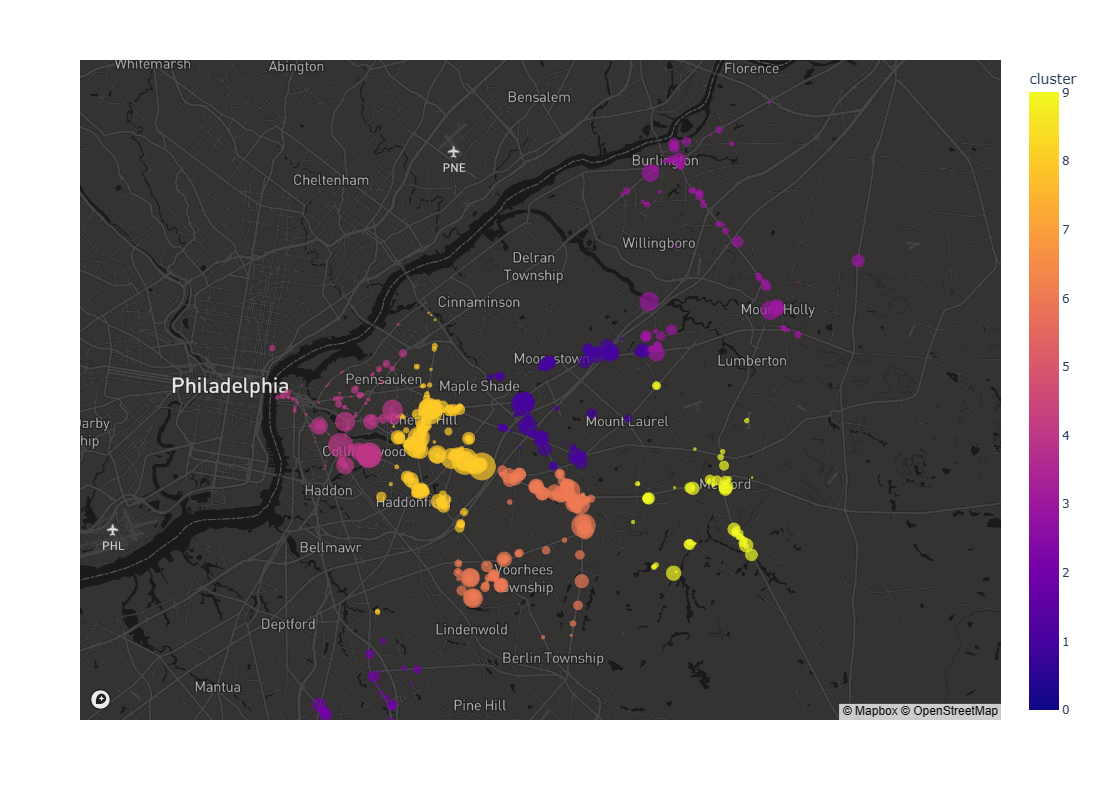

In [175]:
# Geographical Plot of 10 Clusters

px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
fig = px.scatter_mapbox(business_final, lat="latitude", lon="longitude", color="cluster", size='review_count',
                  hover_data= ['name', 'latitude', 'longitude'], zoom=10, width=1000, height=800)

fig.update_layout(mapbox_style="dark")
fig.show()

In [176]:
# Sort Restaurants based on Stars(rating) and subsequently by Review_count

top_restaurants_nj = business_final.sort_values(by=['stars', 'review_count'], ascending=False)
top_restaurants_nj.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster,cluster
408,2AIMA1qpy-O5G-YEbjI0lQ,Gyro Express,"Restaurants, Afghan, Middle Eastern",5.0,74,40.220153,-74.765503,8608,1,0
459,dXBXHaPCnJK2cqNb1xKKjg,Tigas Artisan Pizzeria,"Sandwiches, Restaurants, Salad, Pizza",5.0,66,39.871208,-74.810653,8055,3,9
569,E1EuIHgjBvYcs8Uu_SyV4A,Evermore Coffee Roasters,"Cafes, Restaurants, Coffee Roasteries, Coffee ...",5.0,50,40.079565,-74.857823,8016,3,3
570,NAqhpVl3LLZQd_Ohsbjw1Q,Haddon Culinary,"Comfort Food, Sandwiches, Event Planning & Ser...",5.0,47,39.916034,-75.067571,8108,2,4
40,uz0Af3aczwENPY48UUEY0Q,Valente’s Cucina,"Italian, Farmers Market, Tapas/Small Plates, S...",5.0,45,39.897279,-75.031978,8033,2,8


In [177]:
def location_based_recommendation(df, latitude, longitude, kmeans_model):
    """Predict the cluster for longitude and latitude provided"""
    cluster = kmeans_model.predict(np.array([longitude, latitude]).reshape(1, -1))[0]
    result_string = f"This restaurant belongs to cluster: {cluster}"

    # Set feature names to cluster_centers_
    kmeans_model.cluster_centers_ = np.array([[longitude, latitude]])

    """Get the best restaurant in this cluster along with the relevant information for a user to make a decision"""
    result_df = df[df['cluster'] == cluster].iloc[0:10][['name', 'latitude', 'longitude', 'categories', 'stars', 'review_count', 'cluster']]

    return result_string, result_df

In [178]:
reviews_df = pd.read_csv("E:/Pace/final/final_reviews.csv")
users_df = pd.read_csv("E:/Pace/final/users_final.csv")
businesses_df = pd.read_csv("E:/Pace/final/business_final.csv")

In [179]:
# reviews_df.shape
print(reviews_df.columns)
reviews_df.head()

Index(['Unnamed: 0', 'business_id', 'user_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'year', 'month', 'time', 'word_count',
       'char_count', 'avg_word_len', 'stopword_count', 'cleaned_text',
       'polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound',
       'Dominant_Topic', 'Keywords', 'Text_Chunks'],
      dtype='object')


,Unnamed: 0,business_id,user_id,stars,useful,funny,cool,text,date,year,...,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,Dominant_Topic,Keywords,Text_Chunks
0,0,SlLfWzeYOrVBxCd-0QILZQ,FLGFtGbXaUo0obR6lnZA1Q,5.0,2.0,0.0,1.0,My 2nd experience here was even better than th...,2017-02-19 21:43:00,2017.0,...,2nd experience even better first. believe kink...,0.306429,0.480476,0.000,0.742,0.258,0.9869,1.0,"food, place, great, service, well, love, alway...","['experience', 'well', 'first', 'believe', 'gr..."
1,1,sLgIenN5t-fFALQUkOvCyQ,tVMwKnashaK7V00XIRjtgw,5.0,1.0,0.0,0.0,We really liked this place. Everything we had ...,2018-02-01 22:44:20,2018.0,...,really liked place. everything delicious. port...,0.200000,0.570000,0.000,0.686,0.314,0.9091,1.0,"food, place, great, service, well, love, alway...","['really', 'like', 'place', 'delicious', 'port..."
2,2,Wr2k0Vz8RbcumYulp-jIrA,MLjsIHbz1UWQ65wGSs0Cqw,5.0,0.0,0.0,0.0,I love this place...stop whenever I can; eithe...,2015-05-12 18:07:21,2015.0,...,love place...stop whenever can; either locatio...,0.335714,0.435714,0.031,0.718,0.251,0.9686,1.0,"food, place, great, service, well, love, alway...","['love', 'place', 'stop', 'location', 'eat', '..."
3,3,hqm2zJ1WY5UaVGZ6j07NNA,mCWR0MzqZE3sKB0mwLjLTw,4.0,0.0,0.0,0.0,"Very impressed with this place, particularly t...",2016-07-03 17:36:30,2016.0,...,"impressed place, particularly menu (amazing) f...",0.431622,0.552046,0.077,0.721,0.201,0.9273,1.0,"food, place, great, service, well, love, alway...","['impressed', 'place', 'particularly', 'menu',..."
4,4,r43DrfYAbAgifsYyNkljZw,wLFuvZ59HGUJZ3QBgqlmAg,1.0,0.0,0.0,0.0,"For many years, RH&B was the place to go in so...",2018-09-25 13:10:02,2018.0,...,"many years, rh&b place go south jersey great b...",0.340862,0.433333,0.141,0.750,0.109,0.1506,1.0,"food, place, great, service, well, love, alway...","['year', 'great', 'bbq', 'blue', 'sadly', 'rec..."


In [180]:
users_df.shape
users_df.columns

Index(['Unnamed: 0', 'user_id', 'user_name', 'user_review_count',
       'user_yelp_since', 'friends', 'useful_reviews', 'funny_reviews',
       'cool_reviews', 'n_fans', 'average_stars'],
      dtype='object')

In [181]:
businesses_df.shape
businesses_df.columns
businesses_df.rename(columns={'business_id ': 'business_id'}, inplace=True)
businesses_df

,Unnamed: 0,business_id,name,city,state,stars,review_count,categories,latitude,longitude,is_open,postal_code,key
0,73,8rb-3VYXE37IZix4yOdskw,Sharky's Sports Bar & Grill,Williamstown,NJ,2.5,29,"American (Traditional), Bars, Nightlife, Sport...",39.696801,-74.999821,1,8094,8rb-3VYXE37IZix4yOdskw
1,88,LhpPSrulqVeTyJeK2xydvQ,Fresh Fruits & Salads,Camden,NJ,4.5,6,"Juice Bars & Smoothies, Restaurants, Fruits & ...",39.946690,-75.123327,1,8102,LhpPSrulqVeTyJeK2xydvQ
2,167,Ms5xG8i4p80KSMcF3tt4ug,Sal DeForte's Ristorante,Ewing,NJ,4.0,52,"Italian, Restaurants",40.266888,-74.805657,1,8628,Ms5xG8i4p80KSMcF3tt4ug
3,415,Wt1W6qwCvna1KzIuJRJbwA,Tokyo Mandarin,Glassboro,NJ,4.0,88,"Japanese, Restaurants, Sushi Bars, Chinese",39.711938,-75.110967,1,8028,Wt1W6qwCvna1KzIuJRJbwA
4,552,SlLfWzeYOrVBxCd-0QILZQ,The Boiling House,Cherry Hill,NJ,4.0,238,"Cajun/Creole, Seafood, Noodles, Restaurants",39.899661,-74.953300,1,8003,SlLfWzeYOrVBxCd-0QILZQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,149306,dJ8W2kGq7akECxZxu-hg-g,Kiwi Yogurt,Moorestown,NJ,4.0,39,"Ice Cream & Frozen Yogurt, Restaurants, Food",39.940770,-74.963596,1,8057,dJ8W2kGq7akECxZxu-hg-g
1233,149496,-O_IkEBfG-63san1Pwg2Tg,Golden Dynasty Chinese Takeout,Sicklerville,NJ,4.5,36,"Chinese, Restaurants",39.750399,-75.024127,1,8081,-O_IkEBfG-63san1Pwg2Tg
1234,149666,lK8ExfCP4xsmInhmhCFPew,Aloha Poke,Glassboro,NJ,4.0,5,"Poke, Hawaiian, Asian Fusion, Chicken Shop, Re...",39.702327,-75.110969,1,8028,lK8ExfCP4xsmInhmhCFPew
1235,149908,h-g_XhTlQ_FcCj_5QhLprQ,Scotto Pizza Cafe,Mount Laurel,NJ,4.0,40,"Pizza, Restaurants, Food, Italian",39.971930,-74.874646,1,8054,h-g_XhTlQ_FcCj_5QhLprQ


In [182]:
print("Columns in reviews_df:", reviews_df.columns)
print("Columns in businesses_df:", businesses_df.columns)

Columns in reviews_df: Index(['Unnamed: 0', 'business_id', 'user_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'year', 'month', 'time', 'word_count',
       'char_count', 'avg_word_len', 'stopword_count', 'cleaned_text',
       'polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound',
       'Dominant_Topic', 'Keywords', 'Text_Chunks'],
      dtype='object')
Columns in businesses_df: Index(['Unnamed: 0', 'business_id', 'name', 'city', 'state', 'stars',
       'review_count', 'categories', 'latitude', 'longitude', 'is_open',
       'postal_code', 'key'],
      dtype='object')


In [183]:
# Load English stopwords
stop_words = set(stopwords.words('english'))

# Step 1: Extract business_id and text
new_df = reviews_df[['business_id', 'text']].copy()

# Step 2: Remove numbers, special characters, links, dollar values, and stopwords
def preprocess_text(text):
    # Remove links
    text = re.sub(r'http\S+', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove special characters except for letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove dollar values
    text = re.sub(r'\$\d+(\.\d{1,2})?', '', text)
    # Convert text to lowercase and remove stopwords
    text = ' '.join([word.lower() for word in text.split() if word.lower() not in stop_words])
    return text

new_df['text'] = new_df['text'].apply(preprocess_text)

# Step 3: Normalize text
new_df['text'] = new_df['text'].apply(lambda x: x.lower())

# Step 4: Group by business_id and concatenate text
new_df = new_df.groupby('business_id')['text'].apply(lambda x: ', '.join(x)).reset_index()

# Step 5: Merge with businesses_df on business_id
merged_df = pd.merge(new_df, businesses_df, on='business_id')

# Step 6: Create a new column by concatenating text and categories
merged_df['text_category'] = merged_df['text'] + ', ' + merged_df['categories']

# Display the resulting dataframe
merged_df['city']

0        Mount Holly
1        Cherry Hill
2       Sicklerville
3        Cherry Hill
4         Burlington
            ...     
1232    Williamstown
1233    Sicklerville
1234         Medford
1235         Trenton
1236          Sewell
Name: city, Length: 1237, dtype: object

In [184]:
merged_df.columns
merged_df[merged_df['stars']==4.5]['stars'].value_counts()

stars
4.5    172
Name: count, dtype: int64

In [185]:
# # Rename columns and normalize text
# merged_df.rename(columns={'stars_x': 'stars'}, inplace=True)
# merged_df['normalized_text'] = merged_df['text'].apply(lambda x: x.lower())\
# Rename columns
merged_df.rename(columns={'stars_x': 'stars'}, inplace=True)

# Calculate average star rating grouped by restaurant name
merged_df['stars'] = merged_df.groupby('name')['stars'].transform('mean')

# Round off stars to the nearest integer
merged_df['stars'] = merged_df['stars'].round()

# Drop duplicates keeping the first occurrence
merged_df = merged_df.drop_duplicates(subset=['name'])

# Reset index
merged_df = merged_df.reset_index(drop=True)

# Print first few rows to verify changes
merged_df.columns

Index(['business_id', 'text', 'Unnamed: 0', 'name', 'city', 'state', 'stars',
       'review_count', 'categories', 'latitude', 'longitude', 'is_open',
       'postal_code', 'key', 'text_category'],
      dtype='object')

In [186]:
# Merge text and category columns and profile
# merged_df['text_category'] = merged_df['normalized_text'] + ',' + merged_df['categories']
text_category_profile = merged_df['categories'].apply(lambda x: len(x.split()))

In [187]:
stop_words = ['english']  # Define your stop words list
# merged_df['normalized_text'] = merged_df['normalized_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
merged_df['text_category'] = merged_df['categories'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [188]:
stop_words = ['english']  # Define your stop words list
# merged_df['normalized_text'] = merged_df['normalized_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
merged_df['text_category'] = merged_df['categories'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [189]:
merged_df['text_category'][0]

'Diners, Shopping, Caterers, Restaurants, Comfort Food, Salad, Event Planning & Services, Desserts, Southern, Breakfast & Brunch, American (Traditional), Food'

In [190]:
from sklearn.model_selection import train_test_split
# Train test split
# X_train_text, X_test_text, y_train, y_test = train_test_split(merged_df['normalized_text'], merged_df['stars'], test_size=0.2, random_state=42)
X_train_text_category, X_test_text_category, y_train, y_test = train_test_split(merged_df['text_category'], merged_df['stars'], test_size=0.2, random_state=42)

# Train TF-IDF Vectorizer
# vectorizer_text = TfidfVectorizer()
vectorizer_text_category = TfidfVectorizer()

# X_train_vectors_text = vectorizer_text.fit_transform(X_train_text)
X_train_vectors_text_category = vectorizer_text_category.fit_transform(X_train_text_category, y_train)

In [191]:
# Train Naive Bayes model
# nb_model_text = MultinomialNB()
# nb_model_text.fit(X_train_vectors_text, y_train)

nb_model_text_category = MultinomialNB()
nb_model_text_category.fit(X_train_vectors_text_category, y_train)

MultinomialNB()

In [192]:
# # Train Linear SVM model
# svm_model_text = LinearSVC(dual=False)
# svm_model_text.fit(X_train_vectors_text, y_train)

svm_model_text_category = LinearSVC(dual=False)
svm_model_text_category.fit(X_train_vectors_text_category, y_train)

LinearSVC(dual=False)

In [193]:
from sklearn.metrics import accuracy_score
# Evaluate accuracy of models
# X_test_vectors_text = vectorizer_text.transform(X_test_text)
X_test_vectors_text_category = vectorizer_text_category.transform(X_test_text_category)

# y_pred_text_nb = nb_model_text.predict(X_test_vectors_text)
y_pred_text_category_nb = nb_model_text_category.predict(X_test_vectors_text_category)

# y_pred_text_svm = svm_model_text.predict(X_test_vectors_text)
y_pred_text_category_svm = svm_model_text_category.predict(X_test_vectors_text_category)

# accuracy_text_nb = accuracy_score(y_test, y_pred_text_nb)
accuracy_text_category_nb = accuracy_score(y_test, y_pred_text_category_nb)

# accuracy_text_svm = accuracy_score(y_test, y_pred_text_svm)
accuracy_text_category_svm = accuracy_score(y_test, y_pred_text_category_svm)

# print("Accuracy of Naive Bayes model on text data:", accuracy_text_nb)
print("Accuracy of Naive Bayes model on text_category data:", accuracy_text_category_nb)

# print("Accuracy of Linear SVM model on text data:", accuracy_text_svm)
print("Accuracy of Linear SVM model on text_category data:", accuracy_text_category_svm)

Accuracy of Naive Bayes model on text_category data: 0.7474747474747475
Accuracy of Linear SVM model on text_category data: 0.7575757575757576


In [194]:
def restaurant_recommendation(text, vectorizer, model, merged_df, city):
    # Normalize the input text
    normalized_text = text.lower()
    # Transform text using pre-fitted vectorizer
    text_vector = vectorizer.transform([normalized_text])
    # Predict star rating
    predicted_stars = model.predict(text_vector)[0]
    # Get restaurants with the predicted star rating
    predicted_restaurants = merged_df[(merged_df['stars'] == predicted_stars) & (merged_df['city'] == city)][['name','stars','city']]

    if not predicted_restaurants.empty:
        # Randomly select a restaurant from the predicted restaurants
        random_index = random.randint(0, len(predicted_restaurants)-1)
        predicted_restaurant = predicted_restaurants.iloc[random_index]

        # Calculate cosine similarity between input text and all restaurant descriptions
        similarity_scores = cosine_similarity(text_vector, X_train_vectors_text_category)
        # Get top similar restaurants (excluding the predicted one)
        top_similar_indices = np.argsort(similarity_scores[0])[:-6:-1]  # Exclude the predicted restaurant itself
        recommended_restaurants = merged_df.iloc[top_similar_indices][(merged_df['city'] == city)][['name','stars','city']]

        return predicted_restaurant, recommended_restaurants

    else:
        print("No predicted restaurants.")
        return None, pd.DataFrame()  # Return None and an empty DataFrame

In [195]:
# Example input text
input_text = "Pizza"
city = 'Trenton'
# Example usage
predicted_restaurant, recommended_restaurants = restaurant_recommendation(input_text, vectorizer_text_category, nb_model_text_category, merged_df, city)

# Print predicted restaurant and recommended restaurants
print("Predicted Restaurant:")
print(predicted_restaurant)

print("\nRecommended Restaurants:")
recommended_restaurants_sorted = recommended_restaurants.sort_values(by='stars', ascending=False)
print(recommended_restaurants_sorted)

Predicted Restaurant:
name     The Big Easy
stars             4.0
city          Trenton
Name: 517, dtype: object

Recommended Restaurants:
                       name  stars     city
301  Peter's Pizza and Deli    4.0  Trenton
141            City Deli II    3.0  Trenton


C:\Users\karan\AppData\Local\Temp\ipykernel_24516\3985341253.py:20: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [196]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]  # Smoothing parameter
}

# Create a grid search object
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train_vectors_text_category, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters
best_model = MultinomialNB(**best_params)
best_model.fit(X_train_vectors_text_category, y_train)

# Evaluate the model on the test set
test_accuracy = best_model.score(X_test_vectors_text_category, y_test)
print("Test Accuracy:", test_accuracy)


Best Hyperparameters: {'alpha': 5.0}
Test Accuracy: 0.7626262626262627


In [197]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# Define the hyperparameter grid
param_grid2 = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'loss': ['hinge', 'squared_hinge']     # Choice of loss function
}

# Create a grid search object
grid_search2 = GridSearchCV(LinearSVC(dual=False), param_grid2, cv=5, scoring='accuracy')

# Perform grid search
grid_search2.fit(X_train_vectors_text_category, y_train)

# Get the best hyperparameters
best_params2 = grid_search2.best_params_
print("Best Hyperparameters:", best_params2)

# Train the model with the best hyperparameters
best_model2 = LinearSVC(dual=False, **best_params2)
best_model2.fit(X_train_vectors_text_category, y_train)

# Evaluate the model on the test set
test_accuracy2 = best_model2.score(X_test_vectors_text_category, y_test)
print("Test Accuracy:", test_accuracy2)


Best Hyperparameters: {'C': 0.001, 'loss': 'squared_hinge'}
Test Accuracy: 0.7626262626262627


C:\Users\karan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\karan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\karan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\karan\AppDa